# Webscrapping steps

#### Big Picture
- get list of urls for all jobs
    - meaning scroll through all urls
- pull data for a subset ~50?
- figure out how to parse those
- 

#### Webscrapping
1. go to indeed.com
2. standardize search with keyword and location
3. click go
land: https://www.indeed.com/jobs?q=data&l=Boston%2C+MA
4. find listing title, save salary range data
5. follow link, append to list of visited listings
6. confirm on indeed.com for structure
7. scrape based on title, post id, body text, posting date, location, company, apply count, etc.
8. append into dataframe
9. step back to
land: https://www.indeed.com/jobs?q=data&l=Boston%2C+MA
10. click next title that is not in visited listings
11. repeat steps 4-9
12. when all links visited, click page 2
land: https://www.indeed.com/jobs?q=data&l=Boston%2C+MA&start=10&pp=AAoAAAFbxSxt-AAAAAENOBA0AQAAxlWukuPRDQFNTykCzO5UTAUO6mGXqsg4Er23KZvD0A
13. repeat 4-9
14. when all links visited, click page +1
land: https://www.indeed.com/jobs?q=data&l=Boston%2C+MA&start=20&pp=ABQAAAFbxSxt-AAAAAENN8auAQEBCGUOQf1bV9sc-lkcHOtTF7KWHslcHFliSxaclu09sE0nkVySI-Z2jxuaH8DoPDibwyxk

#### Do same with another website if more data needed
1. check other job sites to see formatting structure
2. determine which is the best/easiest if needed

## Imports

In [429]:
!pip install lxml

In [430]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from pprint import pprint
import requests
from lxml import html

## Link selection
    - All postings including word data:

In [431]:
search = 'data'
#indeed = 'https://www.indeed.com/jobs?q=data&l=Boston%2C+MA'
link = 'https://www.indeed.com/jobs?q=nlp&l=Boston%2C+MA&start='

    - Postings including only the phrase: "data science"

In [432]:
#generate links
phrase = 'data+science'
loc = 'Boston%2C+MA'
by = '50'
sal = '35k-75k'
anyy = '' #'sql+python+sklearn'
link = 'https://www.indeed.com/jobs?as_and=&as_phr=' + str(phrase) + '&as_any=' + str(anyy) + '&as_not=&as_ttl=&as_cmp=&jt=all&st=&salary=' + str(sal) + '&radius=50&l=' + str(loc) + '&fromage=any&limit=' + str(by) + '&sort=&psf=advsrch'
print(link)

https://www.indeed.com/jobs?as_and=&as_phr=data+science&as_any=&as_not=&as_ttl=&as_cmp=&jt=all&st=&salary=35k-75k&radius=50&l=Boston%2C+MA&fromage=any&limit=50&sort=&psf=advsrch


## Pulling URLs steps

In [433]:
import requests
response = requests.get(link)
HTML = response.text

In [434]:
!pip install lxml
from lxml import html
tree = html.fromstring(HTML)

## Test modification of link

In [435]:
#test links
search_term = 'data source'
location = 'Boston, MA'
link = 'https://www.indeed.com/jobs?q=' + search_term + '&l=' + location + '&start='
link

'https://www.indeed.com/jobs?q=data source&l=Boston, MA&start='

## Functions

In [436]:
#function: give link get tree
def page(link):
    response = requests.get(link)
    HTML = response.text
    return html.fromstring(HTML)

In [437]:
#function: give True if last page
def last_page(link):
    s = page(link).xpath(main_xpath['end'])
    #print(s)
    s = s[-1]
    #print(s)
    if s.split()[-2] == 'Next':
        return False
    else:
        return True

In [438]:
#copied off the web
def go_ahead(question, default="yes"):
    import sys
    """Ask a yes/no question via raw_input() and return their answer.

    "question" is a string that is presented to the user.
    "default" is the presumed answer if the user just hits <Enter>.
        It must be "yes" (the default), "no" or None (meaning
        an answer is required of the user).

    The "answer" return value is True for "yes" or False for "no".
    """
    valid = {"yes": True, "y": True, "ye": True,
             "no": False, "n": False}
    if default is None:
        prompt = " [y/n] "
    elif default == "yes":
        prompt = " [Y/n] "
    elif default == "no":
        prompt = " [y/N] "
    else:
        raise ValueError("invalid default answer: '%s'" % default)

    while True:
        sys.stdout.write(question + prompt)
        choice = input().lower()
        if default is not None and choice == '':
            return valid[default]
        elif choice in valid:
            return valid[choice]
        else:
            sys.stdout.write("Please respond with 'yes' or 'no' "
                             "(or 'y' or 'n').\n")

In [439]:
def search(search_term,location='Boston, MA'):
    master_dict = {}
    i = 0
    search_term = search_term
    
    #construct link
    link = 'https://www.indeed.com/jobs?q=' + search_term + '&l=' + location + '&start='
    link_numbered = link

    #notify user of total postings
    print(' ----- ' + str(page(link).xpath(main_xpath['job_count'])[0].split()[-1]) + ' listings ----- ')

    #ask for the go ahead
    if go_ahead('Continue?') == True:
        while last_page(link_numbered) == False:
            #generate next numbered link
            link_numbered = link + str(i)

            #print current state of jobs
            print(page(link_numbered).xpath(main_xpath['job_count']))

            #lists of
            titles = page(link_numbered).xpath(main_xpath['job_title'])
            urls = page(link_numbered).xpath(main_xpath['job_url'])

            #add the data
            for job, url in zip(titles,urls):
                master_dict[job] = url

            #followup
            i += 10
        print(' ----- Done ----- ')
    else:
        print(' ----- Cancelled ----- ')
    return master_dict

In [440]:
def search_num(search_term,location='Boston MA'):
    master_dict = {}
    i = 0
    search_term = search_term
    
    #construct link
    link = 'https://www.indeed.com/jobs?q=' + search_term + '&l=' + location + '&start='
    #link = 'https://www.indeed.com/jobs?q=' + search_term + '&l=' + location + '&start='
    link_numbered = link

    #notify user of total postings
    status = page(link).xpath(main_xpath['job_count'])[0].split()[-1]
    last_status = ''
    print(' ----- ' + str(status) + ' listings ----- ')
    postings = page(link).xpath(main_xpath['job_count'])[0].split()[-1].replace(',','')
    

    #ask for the go ahead
    if go_ahead('Continue?') == True:
        #while last_status != page(link_numbered).xpath(main_xpath['job_count'])[0].split()[-1]:
        while i < int(postings):
            #generate last status
            #last_status = page(link_numbered).xpath(main_xpath['job_count'])[0].split()[-1]        
            
            #generate next numbered link
            link_numbered = link + str(i)

            #print current state of jobs
            print(page(link_numbered).xpath(main_xpath['job_count']))

            #lists of
            titles = page(link_numbered).xpath(main_xpath['job_title'])
            urls = page(link_numbered).xpath(main_xpath['job_url'])
            ids = page(link_numbered).xpath(main_xpath['job_id'])

            #add the data
            for job, url, iden in zip(titles,urls,ids):
                master_dict[iden] = url

            #followup
            i += 50
        print(' ----- Done ----- ')
    else:
        print(' ----- Cancelled ----- ')
    return master_dict

In [531]:
#function to generate link
def gen_link(phrase,sal='',anyy='',loc='Boston%2C+MA',title=''):
    link = 'https://www.indeed.com/jobs?as_and=&as_phr=' + str(phrase) + '&as_any=' + str(anyy) + '&as_not=&as_ttl=' + str(title) + '&as_cmp=&jt=all&st=&salary=' + str(sal) + '&radius=50&l=' + str(loc) + '&fromage=any&limit=' + str(by) + '&start=0'# + str(i) + 'sort=&psf=advsrch'
    return link

In [584]:
def search_many(phrase,sal='',anyy='',loc='Boston%2C+MA',title=''):
    '''
    Requires:
        phrase: 'data+science'
        sal: '10k-100k'
        anyy (any words that match): 'python+matplotlib+etc'
        loc: 'Boston, MA'
    '''
    
    
    master_dict = {}
    i = 0
    by = '50'
    
    #construct link
    #link = 'https://www.indeed.com/jobs?as_and=&as_phr=' + str(phrase) + '&as_any=' + str(anyy) + '&as_not=&as_ttl=&as_cmp=&jt=all&st=&salary=' + str(sal) + '&radius=50&l=' + str(loc) + '&fromage=any&limit=' + str(by) + '&start=' + str(i)# + 'sort=&psf=advsrch'
    link = gen_link(phrase,sal,anyy,loc,title)
    link_numbered = link

    #notify user of total postings
    status = page(link).xpath(main_xpath['job_count'])[0].split()[-1]
    last_status = ''
    print(' ----- ' + str(status) + ' listings ----- ')
    postings = page(link).xpath(main_xpath['job_count'])[0].split()[-1].replace(',','')
    

    #ask for the go ahead
    #if go_ahead('Continue?') == True:
    
    postings = 1500
    
    #while last_status != page(link_numbered).xpath(main_xpath['job_count'])[0].split()[-1]:
    while i < int(postings):
        #generate last status
        #last_status = page(link_numbered).xpath(main_xpath['job_count'])[0].split()[-1]        

        #generate next numbered link
        link_numbered = link + str(i)
        #print(link_numbered)

        #print current state of jobs
        print(page(link_numbered).xpath(main_xpath['job_count']))

        #lists of
        titles = page(link_numbered).xpath(main_xpath['job_title'])
        urls = page(link_numbered).xpath(main_xpath['job_url'])
        ids = page(link_numbered).xpath(main_xpath['job_id2'])
        salaries = [sal]*len(ids)
        phrases = [phrase]*len(ids)
        locs = [loc]*len(ids)

        #add the data
        for job, url, iden, sal, phra, loc in zip(titles,urls,ids,salaries,phrases,locs):
            master_dict[iden] = [job,url,sal,phra,loc]

        #followup
        i += int(by)
    print(' ----- Done ----- ')
    #else:
        #print(' ----- Cancelled ----- ')
    return master_dict

In [443]:
#function dictionary to df with formatted url
def to_df(master_dict,save=False,save_name=''):
    df = pd.DataFrame(master_dict).T
    df.columns=['title','url','sal','search_phrase','search_loc']
    df['url'] = 'https://www.indeed.com' + df['url']
    df['frmt'] = df['url'].apply(lambda url: 'https://www.indeed.com/company' in url)
    if save == True:
        df.to_csv(save_name,index=False)
    return df

## Xpath search term to pull all urls for listings off Indeed.com main listing page

In [444]:
#xpath queries
main_xpath = {'job_title':"//div[contains(@class,'result')]//a[@data-tn-element='jobTitle']/@title",
             'job_url':"//div[contains(@class,'result')]//a[@data-tn-element='jobTitle']/@href",
             'job_id':"//div[contains(@class,'result')]/@data-jk",
             'job_id2':"//div/@data-jk",
             'end':"//div[@class='pagination']//span[@class='pn']/span[@class='np']/text()",
             'job_count':"//div[@id='searchCount']/text()"}

## Test search_many and to_df
    - search_many(phrase,sal,anyy,loc)
    
    - to_df has save to csv functionalisty, takes (dict,save=True,save_name.csv)

In [445]:
#generate link
gen_link(phrase='',title='junior')

'https://www.indeed.com/jobs?as_and=&as_phr=&as_any=&as_not=&as_ttl=junior&as_cmp=&jt=all&st=&salary=&radius=50&l=Boston%2C+MA&fromage=any&limit=50&start=0'

In [446]:
ml_bos = search_many('monkey',sal='50k-100k')
#to_df(ml_bos)

 ----- 4 listings ----- 
['Jobs 1 to 4 of 4']
 ----- Done ----- 


In [447]:
ml_df = to_df(ml_bos)

In [448]:
ml_df

,title,url,sal,search_phrase,search_loc,frmt
26b6accfc40c435e,Sr Business Development Representative,https://www.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0BToeSZs6_IDICFeavQGCZvkEvfO2uGmZ06rb83YapU52IM438bZCx0IMlpkDRU_p9X0_xuoFkxsTgHmGtKISmo09J9uzamFUyWt7Cof_UlGNYraC7My0es24jM_FuhZZi_7JiawNM_VmkI1dr-m4iR0EldQk9Vz0KZY2uoLXacEfvx0nxA0e6O-26VaidBZPLJG7VeM1524yZoXUMlYN4f3564UEZlizGgCqPov70uUF54llioOL8ylbPX8bJTQLSN1k9mDe9fpmiXVti2v2Hc2X835T0u57npLoVXfvY_f6VUsNA7nrZnS1lbkff5xNDqZMjXzGs-5xXHDqprdIQg7s0ndBxoVZN0faVl1Aps14rc_2Hp9_rHYOmYgCboDyMbe9H1HAIn2Mdh4As1Nk9PbKSxifduXaqQBK4jeiuk0VJJZkxLLKDRwnewqFa4DGf9sNeagrk4TPGD3iz3NToGsNQ8xtUOFqDKaNff-MvYfRH1pVY4a2KuEXmzYESBcKA=&p=1&sk=&fvj=1,50k-100k,monkey,Boston%2C+MA,False
6008873bf3098e54,Retail Sales Leader,https://www.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0Dbro9sXpi4VAQyxmEDOUA-qKHV9JlSAeuwHgNeAiLDdXzrvzngRYyQxDvSRkOl_IvsOLNCVvMsIvhYInV9byRLRLszD_SjdBShD0dQFc_5LqyT3POiUMUcJr-QQfqddnBPx3hfw_1K7EBKUizhiUn4zNcfbnGQiK1cRMj-n45x036xI_uRMqOAcVy3RiPBXouK_FQeDr4dflQW4Z7e31LoUU1Dxfn0gRZy7Znl1MpAfAwD9PA0swzb_CmYEIdbaxtv0d3vslhvdtlZGbJM2Q5rVSlPnQIdgvkD69e8COk5DF4tzcIVmDhNIRDTf1F7xX9FezWm67JRc8wVVuHYi0lhuiYFT1ViuRRM0kzHwGcpJVVkaXyRaihy8cq2ndubDgFPVSBtQQWSURw_L0Z_tvrh1cF7qGl_BPcSok7yY5kTOLuwOlnzC6wviII11TEoj6BCzhUBYDRVBNS5QXH6OtDYP5D72tRjdjGoyKP4KZvcHkEL9Aih4jnp9xTr3C3I5xj9EzwVJK2acw==&p=2&sk=&fvj=0,50k-100k,monkey,Boston%2C+MA,False
63eec47be43f66a3,"Associate Director, L&D and Talent Management",https://www.indeed.com/rc/clk?jk=63eec47be43f66a3&fccid=2b9dfe1f150e8f21,50k-100k,monkey,Boston%2C+MA,False
94ec837898da2a42,"Client Marketing Manager, Health Systems",https://www.indeed.com/rc/clk?jk=9956a074e7f6c0dd&fccid=75b1a0eeade24b1a,50k-100k,monkey,Boston%2C+MA,False
9956a074e7f6c0dd,Consumer Engagement Marketing Manager (Mobile and Email),https://www.indeed.com/rc/clk?jk=94ec837898da2a42&fccid=75b1a0eeade24b1a,50k-100k,monkey,Boston%2C+MA,False
a59a30ce1d51f955,Healthcare Client Marketing Manager,https://www.indeed.com/rc/clk?jk=a59a30ce1d51f955&fccid=75b1a0eeade24b1a,50k-100k,monkey,Boston%2C+MA,False


In [449]:
#10% of listings are indeed ones
ml_df[ml_df['frmt'] == 1]['url'].count() / len(ml_df)

0.0

In [450]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


## Loop for Salary Ranges and pull real data

In [451]:
# dst_link_dict = {}
# #phrase='machine+learning'
# phrase='monkey'
# #phrase='data+scientist'
# #phrase='data+analyst'
# #phrase='research+scientist'
# #phrase='business+intelligence'
# #phrase='artificial+intelligence'
# #phrase='deep+learning'
# #phrase='nlp'
# #phrase='business+analyst'


# #anyy = 'data+scientist'
# anyy = ''

# #run
# #sal_list = ['50k-70k','70k-90k','90k-110k','110k-130k','130k-150k','150k-250k']
# sal_list = ['120k']
# for sal in sal_list:
#     #link = 'https://www.indeed.com/jobs?as_and=&as_phr=' + str(phrase) + '&as_any=' + str(anyy) + '&as_not=&as_ttl=&as_cmp=&jt=all&st=&salary=' + str(sal) + '&radius=50&l=' + str(loc) + '&fromage=any&limit=' + str(by) + '&sort=&psf=advsrch'
#     #link = gen_link(phrase,sal=sal)
#     dst_link_dict[sal] = search_many(phrase,sal,anyy=anyy)

## Save each range in a csv

In [452]:
#save all salaries in csvs
# for sal in sal_list:
#     to_df(dst_link_dict[sal],True,'Phrase'+str(phrase)+str(sal)+'.csv')

## Check it saved

In [453]:
!ls './Boston'

'ls' is not recognized as an internal or external command,
operable program or batch file.


## Download the html from all Indeed-formatted Jobs

In [454]:
#ml_df = to_df(dst_link_dict['90k-110k'])

KeyError: '90k-110k'

In [ ]:
#a = to_df(ny_monkey)
#a[a['title'].str.contains('Engineer')]['url']
#a['indeed_listing'] = 
#a[a['url'].str.contains('https://www.indeed.com/company')]
#a['indeed_listing'] = a['url'].apply(indeed)
#a['in'] = a['url'].apply(lambda url: 'https://www.indeed.com/company' in url)

In [ ]:
#ml_df['url']

In [455]:
#check if its got indeed format
# for url in ml_df[ml_df['frmt'] == 1]['url']:
#     print(url)

## Take csv files that are within a path specified:
    - group them into single df
    - only select indeed formatted jobs
    - download and add html raw text to df

In [456]:
def add_html(url):
    response = requests.get(url)
    return response.text

In [457]:
#phrase='machine+learning'

def dl_html(phrase,path='./'):
    import glob
    #grab all csvs with that name
    globbed_csvs = glob.glob(path + "*" + str(phrase) + "*.csv")

    print('----- Combining dfs -----')

    #put them in a single df
    combined_df = pd.DataFrame()
    df_list = []
    for f in globbed_csvs:
        dfn = pd.read_csv(f, header=0,encoding = "ISO-8859-1") #index=False
        df_list.append(dfn)
    combined_df = pd.concat(df_list)
    
    #only keep indeed listings
    combined_df = combined_df[combined_df['frmt'] == 1]
    
    #drop_duplicates based on unique url
    combined_df = combined_df.drop_duplicates(subset=['url'])
    
    #add blank col
    combined_df['html'] = ''
    
    print('----- Adding Html -----')
    
    #download the html and put it in the combined df
    combined_df['html'] = combined_df['url'].apply(add_html)
        
    return combined_df

#df = dl_html('machine+learning')

## Parse Indeed Job Listings for wording

In [458]:
#df['url'].head(2)

## Breakthrough - //text()

In [459]:
#xpath queries
desc_xpath = {'comp_name':"//div[@data-tn-component='jobHeader']/span[@class='company']/text()",
             'job_title':"//div[@data-tn-component='jobHeader']/b/font/text()",
             'job_loc':"//div[@data-tn-component='jobHeader']/span[@class='location']/text()",
             'job_summary':"//td[@class='snip']/span[@id='job_summary']//text()",
             'job_count':"//div[@id='searchCount']/text()"}

## Make functions to add these

In [460]:
from lxml import html

In [461]:
def tree(HTML):
    return html.fromstring(HTML)

In [462]:
def parse_comp_name(html):
    return tree(html).xpath(desc_xpath['comp_name'])[0]

In [463]:
def parse_job_title(html):
    return tree(html).xpath(desc_xpath['job_title'])[0]

In [464]:
def parse_job_loc(html):
    return tree(html).xpath(desc_xpath['job_loc'])[0]

In [465]:
def parse_job_summary(html):
    return tree(html).xpath(desc_xpath['job_summary'])

In [466]:
def str_summary(job_summary):
    return ' '.join(job_summary)

## Add parsed rows to the dataframe

In [467]:
df['comp_name'] = df['html'].apply(parse_comp_name)
df['job_title'] = df['html'].apply(parse_job_title)
df['job_loc'] = df['html'].apply(parse_job_loc)
df['job_summary'] = df['html'].apply(parse_job_summary)
df['job_summary'] = df['job_summary'].apply(str_summary)

## EDA the job summary text

In [468]:
df = df.reset_index()
df.drop('index',axis=1,inplace=True)
df.drop('html',axis=1,inplace=True)

In [469]:
df.groupby('sal').size()

sal
100k-130k    82 
130k-250k    23 
30k-70k      90 
70k-100k     216
dtype: int64

In [470]:
#sal_list = ['50k-70k', '70k-90k', '90k-110k', '110k-130k', '130k-150k', '150k-250k']

#sal110to130 = df[df['sal'] == '110k-130k']['job_summary']
#sal50to70 = df[df['sal'] == '50k-70k']['job_summary']

### df['job_title'].str.contains('A')

In [471]:
#example pull direct from internet
link = 'https://www.indeed.com/company/Newton-Colmore-Consulting-Ltd/jobs/Data-Scientist-Deep-Learning-0b97704eee16f3be?fccid=66a59a212fc22e05'

print(page(link).xpath(desc_xpath['comp_name']))
print(page(link).xpath(desc_xpath['job_title']))
print(page(link).xpath(desc_xpath['job_loc']))
print(page(link).xpath(desc_xpath['job_summary']))

['Newton Colmore Consulting Ltd']
['Data Scientist – Deep Learning – Boston']
['Boston, MA']
['Data Scientist – Deep Learning – Boston', 'Are you an experienced computer scientist who is looking for a new role within a fun, fast-paced commercial environment? A small, tight knit team in Boston are looking for passionate Data Scientists to join their award-winning team of engineers and programmers.', 'This exciting new role will give the Data Scientist an excellent opportunity to work on some really exciting and cutting edge products within the computer vision and machine learning fields. As this is a relatively small team, you will need to take a hands on approach and career progression opportunities, although based on merit, will be ample. This will give you the opportunity to thrive within one of the fastest growing sectors within technology. On a day to day basis you will use your skills and expertise to develop and test new technologies aimed at visual recognition, image processing 

## Import nltk, the data is saved on my 2nd harddrive so add path

In [472]:
#!pip install nltk
import nltk
nltk.data.path.append("/Volumes/Secondary/")

In [473]:
from collections import Counter

In [474]:
#nltk.download()

## If end up needing to modify stopwords much, can use a set to subtract or add.
operators = set(('and', 'or', 'not'))
stop = set(stopwords...) - operators

## Add Lemmantizer. Takes all variations of the words and groups them together.
    - years, year
    - require, requiring, requires

In [475]:
def count_tokens(df):
    from collections import Counter
    from nltk import word_tokenize
    from nltk import WordNetLemmatizer as wnl
    cnt_list = []
    for sal in df['sal'].unique():
        cnt = Counter()
        for desc in df[df['sal'] == sal]['job_summary']:
            for word in [i for i in word_tokenize(desc.lower()) if i not in stop]:
                #cnt[word] += 1
                cnt[wnl().lemmatize(word)] += 1
        cnt_list.append(cnt)
    return cnt_list

In [476]:
cnt_list = count_tokens(df)
cnt_list[0].most_common(10)

[('business', 534),
 ('experience', 500),
 ('project', 367),
 ('requirement', 271),
 ('system', 249),
 ('required', 245),
 ('year', 237),
 ('team', 226),
 ('management', 222),
 ('skill', 221)]

In [477]:
(cnt_list[0] + cnt_list[1] + cnt_list[2]).most_common(10)

[('business', 1119),
 ('experience', 829),
 ('project', 579),
 ('requirement', 511),
 ('year', 457),
 ('required', 444),
 ('system', 444),
 ('skill', 416),
 ('work', 396),
 ('management', 387)]

# --- Full ---

## All together so far (tier1):
- Pull data for each specified phrase and sal range, for Boston MA.
- Save to csvs in local folder

In [588]:
%time
dst_link_dict = {}

#loc = 'Washington%2C+DC'
#loc = 'New+York%2C+NY'
loc = 'Boston%2C+MA'
by = '50'

#titles = ['junior','senior']
#phrases = ['healthcare','government','insurance','banking']
phrases = ['manufacturing','transportation']

for phrase in phrases:
    dst_link_dict = {}
    
    dst_link_dict[phrase] = search_many(phrase=phrase,sal='',loc=loc,title='')

    #save all salaries in csvs in local folder
    df = to_df(dst_link_dict[phrase],True,'Industry'+str(loc)+str(phrase)+'.csv')

Wall time: 0 ns
 ----- 7,147 listings ----- 
['Jobs 1 to 50 of 7,147']
['Jobs 51 to 100 of 7,147']
['Jobs 101 to 150 of 7,147']
['Jobs 151 to 200 of 7,147']
['Jobs 201 to 250 of 7,147']
['Jobs 251 to 300 of 7,147']
['Jobs 301 to 350 of 7,147']
['Jobs 351 to 400 of 7,147']
['Jobs 401 to 450 of 7,147']
['Jobs 451 to 500 of 7,148']
['Jobs 501 to 550 of 7,148']
['Jobs 551 to 600 of 7,148']
['Jobs 601 to 650 of 7,148']
['Jobs 651 to 700 of 7,148']
['Jobs 701 to 750 of 7,148']
['Jobs 751 to 800 of 7,148']
['Jobs 801 to 850 of 7,148']
['Jobs 851 to 900 of 7,147']
['Jobs 901 to 950 of 7,147']
['Jobs 951 to 1,000 of 7,147']
['Jobs 951 to 1,000 of 7,147']
['Jobs 951 to 1,000 of 7,147']
['Jobs 951 to 1,000 of 7,147']
['Jobs 951 to 1,000 of 7,147']
['Jobs 951 to 1,000 of 7,147']
['Jobs 951 to 1,000 of 7,147']
['Jobs 951 to 1,000 of 7,147']
['Jobs 951 to 1,000 of 7,147']
['Jobs 951 to 1,000 of 7,147']
['Jobs 951 to 1,000 of 7,147']
 ----- Done ----- 
 ----- 10,724 listings ----- 
['Jobs 1 to 50 of 

In [ ]:
# %time
# dst_link_dict = {}

# #loc = 'Washington%2C+DC'
# loc = 'New+York%2C+NY'
# #loc = 'Boston%2C+MA'
# by = '50'

# #phrase='data+science'

# #phrase='machine+learning'
# #phrase='data+scientist'
# #phrase='data+analyst'
# #phrase='research+scientist'
# #phrase='business+intelligence'
# #phrase='business+analyst'

# # phrases = ['machine+learning','data+scientist','data+analyst',
# #            'research+scientist','business+intelligence','business+analyst',]

# for phrase in phrases:
#     dst_link_dict = {}
    
#     #run pull urls
#     #sal_list = ['30k-100k','100k-130k','130k-250k']
#     #sal_list = ['30k-70k','70k-100k','100k-130k','130k-250k']
#     for sal in sal_list:
#         #link = 'https://www.indeed.com/jobs?as_and=&as_phr=' + str(phrase) + '&as_any=' + str(anyy) + '&as_not=&as_ttl=&as_cmp=&jt=all&st=&salary=' + str(sal) + '&radius=50&l=' + str(loc) + '&fromage=any&limit=' + str(by) + '&sort=&psf=advsrch'
#         #link = gen_link(phrase,sal=sal)
#         dst_link_dict[sal] = search_many(phrase,sal,loc=loc)

#     #save all salaries in csvs in local folder
#     for sal in sal_list:
#         df = to_df(dst_link_dict[sal],True,'Phrase'+str(phrase)+str(loc)+str(sal)+'.csv')

## Download html data, group all csvs together (tier2):
- Group all csvs in local path, with title matching 'phrase' and include new column with sal range
- Download html for indeed listings only
- Add columns to df that include parsed data

In [ ]:
!dir

In [ ]:
!ls

In [596]:
t = pd.read_csv('IndustryBoston%2C+MAtransportation.csv',encoding='latin1')

In [595]:
#transportation industry fails for some reason
# save_name = 'transportation'
# #save_name = 'senior'
# df = dl_html(save_name)
# #df = dl_html('machine+learningNew+York')

# df['comp_name'] = df['html'].apply(parse_comp_name)
# df['job_title'] = df['html'].apply(parse_job_title)
# df['job_loc'] = df['html'].apply(parse_job_loc)
# df['job_summary'] = df['html'].apply(parse_job_summary)
# df['job_summary'] = df['job_summary'].apply(str_summary)

# df['job_loc'].head()

# df.to_csv(save_name+'.csv')

----- Combining dfs -----
----- Adding Html -----


IndexError: list index out of range

In [ ]:
# #list index out o frange.. 'machine+learning'
# phrases = ['data+scientist', 'data+analyst'
#            'research+scientist','business+intelligence','business+analyst']

# for save_name in phrases:
#     df = pd.DataFrame()
#     #save_name = 'data+analyst'
#     df = dl_html(save_name)
#     #df = dl_html('machine+learningNew+York')

#     df['comp_name'] = df['html'].apply(parse_comp_name)
#     df['job_title'] = df['html'].apply(parse_job_title)
#     df['job_loc'] = df['html'].apply(parse_job_loc)
#     df['job_summary'] = df['html'].apply(parse_job_summary)
#     df['job_summary'] = df['job_summary'].apply(str_summary)

#     #df['job_loc'].head()

#     df.to_csv(save_name+'.csv')

# Explore dfs, make sure no duplicates
- Create 3 master df's to work off of:
    - industry_df - for LDA and topic clustering practice
    - salary_df - for salary classification (4 ranges, '100k-130k', '130k-250k', '30k-70k', '70k-100k')
    - juniorsenior_df - for attempt to differentiate keywords

### Rolled no duplicates into the html downloading so I didn't waste time

In [479]:
df.shape

(411, 11)

### Junior and Senior postings, not specified for anything other than the title containing junior or senior
- no industry in particular
- over boston and new york

In [ ]:
dfj = pd.read_csv('junior.csv',encoding='latin1')
dfs = pd.read_csv('senior.csv',encoding='latin1')
#df = pd.read_csv('New+York%2C+NYsenior.csv',encoding='latin1')

In [ ]:
dfj['title'] = 'junior'
dfs['title'] = 'senior'

In [ ]:
df = pd.concat([dfj,dfs],axis=0)
df = df.reset_index(drop=True)

In [ ]:
df.shape

In [ ]:
df['title'].value_counts()

In [ ]:
df.columns

In [ ]:
df.index.unique()

In [ ]:
df['sal'].value_counts()

### Set label to numeric, get baseline prediction: .67

In [ ]:
df['title_num'] = df['title'].map({'junior':0,'senior':1})

In [ ]:
df.to_csv('juniorsenior_df')

In [ ]:
#baseline
1- df['title_num'].mean()

### Industry df

In [688]:
df_gov = pd.read_csv('government.csv',encoding='latin1')
df_health = pd.read_csv('healthcare.csv',encoding='latin1')
df_bank = pd.read_csv('banking.csv',encoding='latin1')
df_ins = pd.read_csv('insurance.csv',encoding='latin1')
df_manu = pd.read_csv('manufacturing.csv',encoding='latin1')

In [689]:
group = [df_gov,df_health,df_bank,df_ins,df_manu]
df = pd.concat(group,axis=0)

In [690]:
df.columns

Index(['Unnamed: 0', 'title', 'url', 'sal', 'search_phrase', 'search_loc',
       'frmt', 'html', 'comp_name', 'job_title', 'job_loc', 'job_summary'],
      dtype='object')

In [691]:
df['search_phrase'].value_counts()

manufacturing    219
insurance        205
government       112
healthcare       103
banking          102
Name: search_phrase, dtype: int64

In [692]:
df['search_phrase_num'] = df['search_phrase'].map({'manufacturing':0,
                                                   'insurance':1,
                                                   'government':2,
                                                   'healthcare':3,
                                                   'banking':4})

In [693]:
df.to_csv('industry_df.csv')

### All downloaded positions into single 'salary_df'
- Business Analyst
- Data Scientist
- Data Analyst
- Business Analyst
- etc.

In [599]:
df_ba = pd.read_csv('business+analyst.csv',encoding='latin1')
df_bi = pd.read_csv('business+intelligence.csv',encoding='latin1')
df_rs = pd.read_csv('research+scientist.csv',encoding='latin1')
df_ds = pd.read_csv('data+scientist.csv',encoding='latin1')
df_da = pd.read_csv('data+analyst.csv',encoding='latin1')

In [600]:
group = [df_ba,df_bi,df_rs,df_ds,df_da]
df = pd.concat(group,axis=0)

In [601]:
df['url'].nunique()

1064

In [602]:
df.shape

(1122, 12)

In [11]:
df = pd.read_csv('salary_df.csv',encoding='latin1')

In [603]:
df['sal'].unique()

array(['100k-130k', '130k-250k', '30k-70k', '70k-100k'], dtype=object)

In [620]:
df.columns

Index(['Unnamed: 0', 'title', 'url', 'sal', 'search_phrase', 'search_loc',
       'frmt', 'html', 'comp_name', 'job_title', 'job_loc', 'job_summary',
       'sal_num'],
      dtype='object')

In [631]:
sals = ['30k-70k', '70k-100k','100k-130k', '130k-250k']
mapping = {sal: i for i, sal in enumerate(sals)}
key = df['sal'].map(mapping)    
df = df.iloc[key.argsort()]

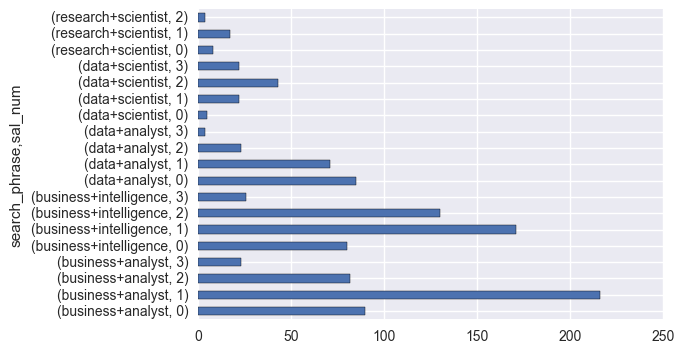

In [680]:
df.groupby(['search_phrase','sal_num']).size().plot.barh()
#df[['sal','search_phrase']].value_counts().plot(kind='bar',title='Total job counts')

In [687]:
df['job_title'].value_counts().head(20)

Business Analyst                    58
Data Analyst                        48
Data Scientist                      23
Senior Business Analyst             14
Sr. Business Analyst                9 
IT Business Analyst                 8 
Business Intelligence Analyst       6 
Financial Analyst                   5 
Senior Data Analyst                 5 
Business Analyst Consultant         5 
Junior Business Analyst             5 
Tableau Developer                   4 
Sr. Data Analyst                    4 
Pricing & Analytics Manager         4 
Technical Business Analyst          4 
SharePoint Developer                4 
Business Intelligence Developer     4 
Research Scientist                  4 
Sr Data Analyst/Business Analyst    3 
Marketing Data Analyst              3 
Name: job_title, dtype: int64

In [604]:
df['sal_num'] = df['sal'].map({'30k-70k':0,'70k-100k':1,'100k-130k':2,'130k-250k':3})

In [9]:
#baseline is at 52.5%
df['sal_num'].value_counts().max() / df['sal_num'].count()

0.46739130434782611

In [10]:
df['sal'].value_counts()

100k-130k    43
70k-100k     22
130k-250k    22
30k-70k       5
Name: sal, dtype: int64

In [682]:
#df.to_csv('salary_df.csv')

# Play with sklearn - Salary_df
### Pretty large, if want to quicken up subset based on search phrase

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('salary_df.csv',encoding='latin1')

In [3]:
df['search_phrase'].unique()
df = df[df['search_phrase'] == 'data+scientist']

In [1370]:
df.shape

(1122, 14)

In [5]:
import pandas as pd, seaborn as sns, numpy as np, matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline

%matplotlib inline

sns.set_style("darkgrid")

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

### Add Lemmantizer to the countvectorizer

In [32]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

vect = CountVectorizer(tokenizer=LemmaTokenizer())

In [33]:
import nltk
nltk.data.path.append("/Volumes/Secondary/")
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
additional = ["''","'s",'--','``','·','’',"'"]
stop = stopwords.words('english') + list(string.punctuation) + additional

In [699]:
#check out the countvect
cvt      =  CountVectorizer(stop_words=stop,strip_accents='unicode', 
                            ngram_range=(1,3),max_df=.95,tokenizer=LemmaTokenizer())
X_all    =  cvt.fit_transform(df['job_summary'])
df_wcnt = pd.DataFrame(X_all.toarray(), columns=cvt.get_feature_names())
df_wcnt.sum().sort_values(ascending=False).head(30)

data           4884
business       4785
year           3013
required       2491
requirement    2172
skill          2164
team           2102
work           2073
project        1993
system         1913
management     1905
development    1783
ability        1707
analysis       1635
process        1514
support        1412
analyst        1360
client         1353
solution       1307
type           1213
knowledge      1178
strong         1157
service        1131
technology     1130
job type       1123
technical      1069
application    1065
bachelor       1031
design         991 
including      986 
dtype: int64

In [509]:
# lda      =  LatentDirichletAllocation(n_topics=5)
# X_all_lda    =  lda.fit_transform(X_all)
# df_wcnt = pd.DataFrame(X_all_lda.toarray(), columns=lda.get_feature_names())
# df_wcnt.sum().sort_values(ascending=False).head(10)

In [712]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.grid_search import GridSearchCV

In [702]:
#X = df['job_summary']
X = X_nmf
#y = df['title_num']
y = df['sal_num']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3)

In [ ]:
#pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(lowercase=True, 
                             strip_accents='unicode', 
                             stop_words='english',#stop, 
                             ngram_range=(1,3), 
                             #min_df=.2, 
                             max_df=.7,
                             tokenizer=LemmaTokenizer())),
    ('tfidf', TfidfTransformer()),
#     ('lsa', TruncatedSVD(n_components=100, random_state=42)),
#     ('norm', Normalizer(copy=False)),
#     ('tfidf', TfidfVectorizer(lowercase=True, 
#                               strip_accents='unicode', 
#                               #analyzer='word', 
#                               stop_words='english',
#                               sublinear_tf=True)),
    #('cls', MultinomialNB()),
    #('cls', BernoulliNB()),
    #('cls', LogisticRegression()),
    ('cls', RandomForestClassifier(n_estimators=250, random_state=42))
]) 
pipeline.fit(X_train, y_train)
predicted = pipeline.predict(X_test)
pipeline.score(X_test, y_test)

In [ ]:
#pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(lowercase=True, 
                             strip_accents='unicode', 
                             stop_words=stop, 
                             tokenizer=LemmaTokenizer())),
    ('tfidf', TfidfTransformer()),
#     ('lsa', TruncatedSVD(n_components=100, random_state=42)),
#     ('norm', Normalizer(copy=False)),
#     ('tfidf', TfidfVectorizer(lowercase=True, 
#                               strip_accents='unicode', 
#                               #analyzer='word', 
#                               stop_words='english',
#                               sublinear_tf=True)),
    #('cls', MultinomialNB()),
    #('cls', BernoulliNB()),
    #('cls', LogisticRegression()),
    ('cls', RandomForestClassifier(n_estimators=250, random_state=42))
]) 

parameters = {
    'vect__max_df': (0.5, 0.7, 0.9),
    #'vect__max_features': (None, 10000, 50000, 100000),
    'vect__ngram_range': ((1,2),(2,3),(1,4)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    #'clf__alpha': (0.00001, 0.000001),
    #'clf__penalty': ('l2', 'elasticnet'),
    #'clf__n_iter': (10, 50, 80),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
grid_search.predict(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [571]:
pipeline.named_steps['lsa'].explained_variance_ratio_

array([ 0.00300002,  0.00767697,  0.00733235,  0.00734411,  0.00724985,
        0.00707104,  0.00689441,  0.00675364,  0.00667186,  0.00664868,
        0.00641447,  0.00632008,  0.00625174,  0.00621852,  0.00603695,
        0.00591891,  0.00581175,  0.0057322 ,  0.00549707,  0.00536019,
        0.00516024,  0.00498392,  0.00485568,  0.00469787,  0.0046721 ,
        0.00459683,  0.00454941,  0.00448689,  0.0044314 ,  0.00441211,
        0.00436036,  0.00427168,  0.00424883,  0.00420417,  0.00417799,
        0.00416561,  0.00412052,  0.00410553,  0.00407072,  0.00403555,
        0.00402844,  0.00401838,  0.00399303,  0.00395592,  0.00392304,
        0.00391516,  0.00388927,  0.00386082,  0.00385375,  0.00383647,
        0.00382361,  0.00381965,  0.0038028 ,  0.00378376,  0.00375521,
        0.0037386 ,  0.00372591,  0.00371853,  0.00370092,  0.00369437,
        0.00368934,  0.00367702,  0.00366414,  0.00365038,  0.0036461 ,
        0.00363937,  0.00362682,  0.00361753,  0.0036089 ,  0.00

In [ ]:
df_wcnt = pd.DataFrame(X_all.toarray(), columns=cvt.get_feature_names())
df_wcnt.sum().sort_values(ascending=False).head(30)

In [525]:
#X_test_tf = pipeline.named_steps['tfidf'].fit_transform(X_test)
y_pred_class = pipeline.predict(X_test)

In [528]:
#check out the tfidf
tfidf = TfidfVectorizer(lowercase=True, strip_accents='unicode', #analyzer='word', 
                             stop_words='english',sublinear_tf=True)
X_all    =  tfidf.fit_transform(df['job_summary'])
df_wcnt = pd.DataFrame(X_all.toarray(), columns=tfidf.get_feature_names())
df_wcnt.head()

,00,000,0011,02110,02114,02451,02453,03,03051,07054,...,yields,york,young,youth,youthful,youtube,yrs,zeroed,zones,zynosoft
0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.069441,0.0,0.0,0.0,0.0,0.076852,0.076852,0.0,0.0,0.0,...,0.0,0.038255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [530]:
df_wcnt = pd.DataFrame(X_all.toarray(), columns=pipeline.named_steps['tfidf'].get_feature_names())
df_wcnt

AttributeError: 'TfidfTransformer' object has no attribute 'get_feature_names'

In [531]:
from sklearn import metrics
metrics.confusion_matrix(y_test, y_pred_class)

array([[ 6, 22,  0,  0],
       [ 1, 67,  0,  0],
       [ 0, 23,  0,  0],
       [ 0,  5,  0,  0]])

# Try LDA/NMF topic modeling with industry data

In [1]:
import numpy as np

In [2]:
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
import pandas as pd, seaborn as sns, numpy as np, matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


from sklearn.pipeline import Pipeline

%matplotlib inline

sns.set_style("darkgrid")

In [3]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

vect = CountVectorizer(tokenizer=LemmaTokenizer())

In [4]:
import nltk
nltk.data.path.append("/Volumes/Secondary/")
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
additional = ["''","'s",'--','``','·','’',"'","'re",'/hour','/year','hour required']
stop = stopwords.words('english') + list(string.punctuation) + additional

In [5]:
#df = pd.read_csv('industry_df.csv',encoding='latin1') #
#df = pd.read_csv('juniorsenior_df',encoding='latin1') #94% with randomforrest nmf
df = pd.read_csv('salary_df.csv',encoding='latin1')

In [6]:
df.shape

(1122, 14)

In [7]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'title', 'url', 'sal', 'search_phrase',
       'search_loc', 'frmt', 'html', 'comp_name', 'job_title', 'job_loc',
       'job_summary', 'sal_num'],
      dtype='object')

In [8]:
#baseline
df['sal'].value_counts().max()/df['sal'].count()

0.44295900178253117

In [59]:
X_job = df['job_summary']
X_title = df['job_title']
y_all = df['sal_num']

In [60]:
#check out the countvect
cvt_job      =  CountVectorizer(stop_words=stop,
                            strip_accents='unicode', 
                            ngram_range=(2,4),
                            max_df=.8,
                            min_df=2,
                            tokenizer=LemmaTokenizer())
X_job_cvt    =  cvt_job.fit_transform(X_job)

In [61]:
#check out the countvect
cvt_title      =  CountVectorizer(stop_words=stop,
                            strip_accents='unicode', 
                            ngram_range=(1,1),
                            max_df=.7,
                            min_df=2,
                            tokenizer=LemmaTokenizer())
X_title_cvt    =  cvt_title.fit_transform(X_title)

In [62]:
tf_job = TfidfTransformer()
X_job = tf_job.fit_transform(X_job_cvt)

tf_title = TfidfTransformer()
X_title = tf_title.fit_transform(X_title_cvt)

In [63]:
nmf_title = NMF(n_components=4, 
          random_state=42, 
          alpha=.1, 
          l1_ratio=.9, 
          init='nndsvd').fit(X_title)

nmf_job = NMF(n_components=8, 
          random_state=42, 
          alpha=.1, 
          l1_ratio=.7, 
          init='nndsvd').fit(X_job)

In [64]:
nmf_job_df = pd.DataFrame(nmf_job.components_, columns = cvt_job.get_feature_names())
nmf_job_df = nmf_job_df.replace(0,np.nan)
nmf_job_df = nmf_job_df.dropna(how='all',axis=1)
nmf_job_df = nmf_job_df.replace(np.nan,0)

nmf_title_df = pd.DataFrame(nmf_title.components_, columns = cvt_title.get_feature_names())
nmf_title_df = nmf_title_df.replace(0,np.nan)
nmf_title_df = nmf_title_df.dropna(how='all',axis=1)
nmf_title_df = nmf_title_df.replace(np.nan,0)

In [1369]:
print(nmf_job_df.shape)
print(nmf_title_df.shape)

(5, 2591)
(5, 135)


In [79]:
nmf_job_df.T.sort_values(0,ascending=False).head()

,0,1,2,3,4,5,6,7
1 year,0.474163,0.000000,0.003760,0.000000,0.0,0.0,0.000000,0.0
education bachelor,0.459187,0.002709,0.010208,0.002692,0.0,0.0,0.006184,0.0
required education bachelor,0.438794,0.002892,0.010030,0.002826,0.0,0.0,0.006453,0.0
type full-time required education,0.432659,0.007125,0.000000,0.000000,0.0,0.0,0.000000,0.0
full-time required education,0.432659,0.007125,0.000000,0.000000,0.0,0.0,0.000000,0.0


In [67]:
nmf_title_df.T.sort_values(3,ascending=False).head()

,0,1,2,3
scientist,0.0,0.000000,0.0,4.867121
data,0.0,6.413457,0.0,1.654174
research,0.0,0.000000,0.0,1.006735
learning,0.0,0.000000,0.0,0.089867
clinical,0.0,0.014977,0.0,0.078757


In [68]:
# nmf_df = nmf_df[nmf_df>.1].dropna(how='all',axis=1)
# nmf_df = nmf_df.fillna(0)
# nmf_df.shape

In [69]:
X_nmf = pd.DataFrame()
#for i, j in enumerate(['gov','manu','bank','health','insurance']):
for i in range(4):
    X_nmf = pd.concat([X_nmf,pd.DataFrame(np.matmul(X_job_cvt.toarray(),nmf_job.components_[i]),columns=[i])],axis=1)
    X_nmf = pd.concat([X_nmf,pd.DataFrame(np.matmul(X_title_cvt.toarray(),nmf_title.components_[i]),columns=[i])],axis=1)

# Use this in a model!

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import ShuffleSplit

In [71]:
#X = df['job_summary']
X = X_nmf
#y = df['title_num']
y = df['sal_num']
#y = df['search_phrase']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.4)

In [72]:
clf = RandomForestClassifier(n_estimators=200,random_state=42,criterion='entropy') #did very poorly on 
#clf = RandomForestClassifier(n_estimators=200,random_state=42,criterion='gini')
#clf = LogisticRegression(penalty='l2',C=1) #C=1,L1,.639 (job only)
#clf = LogisticRegression() #job only, .64
#clf = MultinomialNB()
#clf = SVC(C=1,kernel='poly',degree=2) #
#clf = SVC(C=10,gamma=10,kernel='linear',random_state=42) #c=10,.646 (both job+title)

In [73]:
clf.fit(X_train,y_train)
#cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
cross_val_score(clf,X_train,y_train,cv=10).mean()

0.53003663296025016

In [74]:
y_pred = clf.predict(X_test)
y_total_pred = clf.predict(X_nmf)

In [75]:
from sklearn.metrics import confusion_matrix

In [76]:
clf.score(X_test,y_test)

0.534521158129176

In [77]:
confusion_matrix(y_pred, y_test)

array([[ 50,  37,   6,   6],
       [ 35, 132,  42,  11],
       [ 17,  35,  57,  14],
       [  0,   4,   2,   1]])

In [754]:
pd.concat([X_nmf,pd.DataFrame(y),pd.DataFrame(y_total_pred),pd.DataFrame(df['job_title'])],axis=1).head()

,0,1,title_num,0,job_title
0,0.271923,0.000000,0,0,Jr. Paralegal
1,3.624011,0.035767,0,0,Junior Commercial Loan Officer
2,3.666084,0.000470,0,0,Entry Level - Junior Commodities Broker
3,0.271923,0.081740,0,0,Jr. Art Director
4,3.582470,0.000000,0,0,Junior Stylist/Assistant


In [557]:
#df.iloc[29]['job_summary']

In [103]:
lda      =  LatentDirichletAllocation(n_topics=5,max_iter=15,max_doc_update_iter=300)
X_all_lda    =  lda.fit_transform(X_all)
lda_df = pd.DataFrame(X_all_lda)
lda_df.columns = df['search_phrase'].unique()

C:\Users\xbn2\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [104]:
lda_df.head()

,government,healthcare,banking,insurance,manufacturing
0,0.000135,0.000136,0.000137,0.000135,0.999457
1,0.000652,0.240462,0.757581,0.000655,0.000650
2,0.000287,0.998848,0.000291,0.000286,0.000287
3,0.307135,0.580554,0.111763,0.000274,0.000274
4,0.000579,0.000587,0.997671,0.000581,0.000582


In [106]:
df['search_phrase'].head()

0    government
1    government
2    government
3    government
4    government
Name: search_phrase, dtype: object

In [173]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# NMF is able to use tf-idf
tfidf = TfidfVectorizer(lowercase=True, 
                            strip_accents='unicode', 
                            #analyzer='word', 
                            stop_words='english',
                            sublinear_tf=True)
tfidf_job_sum = tfidf.fit_transform(df['job_summary'])
tfidf_feature_names = tfidf.get_feature_names()

nmf = NMF(n_components=5, 
          random_state=1, 
          alpha=.1, 
          l1_ratio=.7, 
          init='nndsvd').fit(tfidf_job_sum)

### Try regex to find experience
keywords to try:
    - certification
    - year/years
    - experience

In [245]:
df.shape

(1122, 14)

In [416]:
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

In [355]:
edu = df['job_summary'].str.extract('((Required education: )\w+)')
edu_col = edu[0].str.extract(r': (\w+)')

/Users/xbno/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':
/Users/xbno/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app


In [356]:
edu_col.unique()

array([nan, 'Bachelor', 'Doctorate', 'Master', 'High', 'Associate',
       'Educación'], dtype=object)

In [357]:
edu_col = edu_col.map({np.nan:3,'Educación':1,'High':1,'Associate':2,'Bachelor':3,'Master':5,'Doctorate':9})

In [358]:
#edu_col

In [359]:
edu[0].count()/len(edu)

0.54634581105169344

In [360]:
#experience
exp = df['job_summary'].str.extract('((Required experience: ).+)')
#exp_col = exp[0].str.findall(r'([A-Z]\w*\s?[A-Z]\w+:[\W\D]+\d?\s\w+)')

/Users/xbno/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app


In [361]:
exp[0].count()/len(exp)

0.65418894830659535

In [362]:
exp_col = exp[0].str.extractall(r'(\d+)\syear')
exp_col = pd.to_numeric(exp_col[0])
exp_col = exp_col.groupby(level=[0]).sum()

In [363]:
phd_col = df['job_summary'].str.extract('(PHD|phd|PhD|P.h.D.)')
#phd_col

/Users/xbno/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


In [364]:
phd_col = phd_col.map({np.nan:0,'PhD':5})

In [365]:
#best so far for numerics before year
#job_df = df['job_summary'].str.extract('([\d\S+-A-Z]+[\W\D]+(years|year))')
#job_df.to_csv('years.csv',index=False)

In [366]:
job = pd.read_csv('years.csv')

In [367]:
job_col = job['0'].str.extractall(r'(\d)(\S?)(\d*)\syear')

In [368]:
y_min = job_col[0]
y_ind = job_col[1]
y_max = job_col[2]

In [369]:
y_min = pd.to_numeric(y_min)
y_max = pd.to_numeric(y_max)

In [370]:
y_min = y_min.groupby(level=[0]).sum()
y_max = y_max.groupby(level=[0]).sum()

In [371]:
y_ind = y_ind.groupby(level=[0]).unique()

In [372]:
group = [edu_col,exp_col,phd_col,y_min,y_max]
ext_df = pd.concat(group,axis=1)

In [373]:
ext_df = ext_df.fillna(0)

In [473]:
X = ext_df
y = df['sal_num']
y = y.map({0:0,1:0,2:1,3:1})
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.4)

In [517]:
#clf = RandomForestClassifier(n_estimators=200,random_state=42,criterion='entropy') #did very poorly on 
#clf = RandomForestClassifier(n_estimators=200,random_state=42,criterion='gini')
#clf = LogisticRegression(penalty='l1',C=10) #C=1,L1,.639 (job only)
#clf = LogisticRegression() #job only, .64
#clf = MultinomialNB()
#clf = SVC(C=1,kernel='poly',degree=2) #
#clf = SVC(C=10,gamma=10,kernel='linear',random_state=42) #c=10,.646 (both job+title)
clf = KNeighborsClassifier(n_neighbors=8)#,metric='manhattan')

In [518]:
clf.fit(X_train,y_train)
#cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
cross_val_score(clf,X_train,y_train,cv=10).mean()

0.67317822651448633

In [519]:
y_pred = clf.predict(X_test)

In [520]:
clf.score(X_test,y_test)

0.69487750556792871

In [521]:
confusion_matrix(y_pred, y_test)

array([[279, 111],
       [ 26,  33]])

In [393]:
#df['job_summary'].str.extract('(years|year)')
#df['job_summary'].str.extract('([\w+]+\W+(years|year)\W+\w+)')

In [394]:
#idx = df.brand.str.contains('^bmw$|^toyota$', flags=re.IGNORECASE, regex=True, na=False)
#df['job_summary'].str.extract('(\w+\s+\w+\s+\w+\s+\w+\s+\w+\s+(experience)\s+\w+\s+\w+\s+\w+\s+)')

# Did this before I knew about the count vectorizer

## Get word counts for each group of salary range:
- Remove stopwords
- Tokenize summary text from all listings in the sal range
- Lemantize words as well - meaning take multiple types of the same word and group together
    - years, year
    - require, requiring, requires
- Get top 10 for each range, and a top 10 for all listing with phrase

In [ ]:
string.punctuation

In [ ]:
cnt_list = count_tokens(df)

In [ ]:
for i in range(len(cnt_list)):
    pprint(cnt_list[i].most_common(10))

In [ ]:
#the minimum count of words existing across all the sal ranges
common_cnt = (cnt_list[0] & cnt_list[1] & cnt_list[2])# & cnt_list[3] & cnt_list[4] & cnt_list[5])


#list of all words that exist across all sal ranges
common_words = (cnt_list[0] & cnt_list[1] & cnt_list[2]).keys()# & cnt_list[3] & cnt_list[4] & cnt_list[5]).keys()

In [ ]:
common_cnt.most_common(5)

In [ ]:
keep_words = list(keep_words)

In [ ]:
keep_skills = [ 'sql',
 'hadoop',
 'java',
 'html',
 'database',
 'c++',
 'nosql',
 'r',
 'cloud',
 'aws',
 'amazon',
 'spark',
 'etl']

In [ ]:
#add counter together to make jumbo total count
for i in range(len(cnt_list)):
    total_cnt += cnt_list[i]

In [ ]:
total_cnt.most_common(5)

In [ ]:
total_cnt_5 = [el for el in total_cnt.elements() if total_cnt[el] >= 5]

In [ ]:
total_cnt['skill']

In [ ]:
#common words across all levels
cnt_list[0](cnt_list[0].keys() - common_words)


In [ ]:
(cnt_list[0])['someone']

In [ ]:
for word in common_words:
    print((cnt_list[0])[word])

<img src="files/indeed.png" style="float: right; height: 100px">


# Indications for Different Types of Jobs on Indeed.com
---
### Goals:
- Determine best indicators of salary range:
    - Skills? 
    - Words? 
    - Experience Required?
    - Education Required?
- Explore unsupervised methods
    - Determine which words indicate which industries

---
# Data Scientist:
<img src="files/circle_wordcloud_ds.png" style="float: left; height: 600px">

---
# Data Analyst:
<img src="files/circle_wordcloud_da.png" style="float: left; height: 600px">

---
### Findings:
- 'Ensemble technique' of both bag of words and specific keywords was the best
    - Regex .03 better than .68 baseline
    - Bag of Words .10 better than .44 baseline
    - Both produced ~.15-.17 better than .44 baseline
- Optimizing each set of approach individually seems powerful
    - I went through optimizing both title and summary which lead to difficulties
    - Whereas I optimized the keywords separately
- By weighting different categorical variables I was able to boost my accuracy:
    - Example: {np.nan:10,'Educación':1,'High':1,'Associate':2,'Bachelor':20,'Master':60,'Doctorate':500}

---

<img src="files/advanced_search.png" style="float: right; height: 400px">
### 3 Sets of Data:
- Labeled Salary data for 5 job types:
    - Salary ranges based on Indeed's advanced search metric:
        - '30k-70k', '70k-100k', '100k-130k', '130k-250k'
    - Phrases searched:

        - Data Scientist, Data Analyst, Research Scientist, Business Intelligence, and Business Analyst
    - Locations searched:
        - Washington DC, Boston, New York
- Unlabeled Junior and Senior positions
    - Title searched:
        - Junior, Senior
- Unlabeled set of 5 Industries:
    - Phrases searched:
        -Government, Healthcare, Manufacturing, Banking, Insuarance

---
### Assumptions/Constraints:
- Only pulled from Indeed website postings, due to consistent format
    - We are assuming that Indeed postings are representitive of all job postings
- ~10% of listings on Indeed are internal Indeed listings
    - To increase sample size I pulled job listings from multiple metro regions
    - Salary differences are negligable across the locations sampled

---

### Format - Indeed vs Other:
<img src="files/other.png" style="float: right; height: 450px">
<img src="files/indeed_post.png" style="float: left; height: 450px">


---
<img src="files/joblist.png" style="float: right; height: 450px">
## Agregatting the data:
- Two steps:
    - __Tier1__: Save all urls in a dataframe
    - __Tier2__: Save the html data for each url to parse later
- Result:
    - End up with 3 master.csvs to run analysis on

---
### Tier 1:
- Manipulate the Indeed advanced search url to pull jobs accordingly:
    - Generate link for each job listings page
        - Luckily this can be incremented by 50 per page
    - Loop through all pages until last job
        - Change the start=50 in url to see jobs 50-100
    - Save search metadata like 'search_phrase','salary','location' etc for each url
        - To use as target variables later on

In [533]:
#search terms
phrase = 'data+science'
loc = 'Boston%2C+MA'
by = '50'
sal = '50k-=100k'

#function to generate link
gen_link(phrase=phrase,sal=sal,loc=loc,title='')

'https://www.indeed.com/jobs?as_and=&as_phr=data+science&as_any=&as_not=&as_ttl=&as_cmp=&jt=all&st=&salary=50k-=100k&radius=50&l=Boston%2C+MA&fromage=any&limit=50&start=0'

In [ ]:
def search_many(phrase,sal='',anyy='',loc='Boston%2C+MA',title=''):
    '''
    Requires:
        phrase: 'data+science'
        sal: '10k-100k'
        anyy (any words that match): 'python+matplotlib+etc'
        loc: 'Boston, MA'
    '''

    master_dict = {}
    i = 0
    by = '50'
    
    #construct link
    #link = 'https://www.indeed.com/jobs?as_and=&as_phr=' + str(phrase) + '&as_any=' + str(anyy) + '&as_not=&as_ttl=&as_cmp=&jt=all&st=&salary=' + str(sal) + '&radius=50&l=' + str(loc) + '&fromage=any&limit=' + str(by) + '&start=' + str(i)# + 'sort=&psf=advsrch'
    link = gen_link(phrase,sal,anyy,loc,title)
    link_numbered = link

    #notify user of total postings
    status = page(link).xpath(main_xpath['job_count'])[0].split()[-1]
    last_status = ''
    print(' ----- ' + str(status) + ' listings ----- ')
    postings = page(link).xpath(main_xpath['job_count'])[0].split()[-1].replace(',','')
    
    #ask for the go ahead
    #if go_ahead('Continue?') == True:

    #added because it wouldn't stop when expected and there would never be over 1500 jobs
    postings = 1500
    
    #while last_status != page(link_numbered).xpath(main_xpath['job_count'])[0].split()[-1]:
    while i < int(postings):
        #generate last status
        #last_status = page(link_numbered).xpath(main_xpath['job_count'])[0].split()[-1]        

        #generate next numbered link
        link_numbered = link + str(i)
        #print(link_numbered)

        #print current state of jobs
        print(page(link_numbered).xpath(main_xpath['job_count']))

        #lists of
        titles = page(link_numbered).xpath(main_xpath['job_title'])
        urls = page(link_numbered).xpath(main_xpath['job_url'])
        ids = page(link_numbered).xpath(main_xpath['job_id2'])
        salaries = [sal]*len(ids)
        phrases = [phrase]*len(ids)
        locs = [loc]*len(ids)

        #add the data
        for job, url, iden, sal, phra, loc in zip(titles,urls,ids,salaries,phrases,locs):
            master_dict[iden] = [job,url,sal,phra,loc]

        #followup
        i += int(by)
    print(' ----- Done ----- ')
    #else:
        #print(' ----- Cancelled ----- ')
    return master_dict

In [ ]:
#function dictionary to df with formatted url
def to_df(master_dict,save=False,save_name=''):
    df = pd.DataFrame(master_dict).T
    df.columns=['title','url','sal','search_phrase','search_loc']
    df['url'] = 'https://www.indeed.com' + df['url']
    df['frmt'] = df['url'].apply(lambda url: 'https://www.indeed.com/company' in url)
    if save == True:
        df.to_csv(save_name,index=False)
    return df

In [ ]:
#loop though search terms
dst_link_dict = {}

#loc = 'Washington%2C+DC'
loc = 'New+York%2C+NY'
#loc = 'Boston%2C+MA'
by = '50'

#phrase='data+science'
#phrase='machine+learning'
#phrase='data+scientist'
#phrase='data+analyst'
#phrase='research+scientist'
#phrase='business+intelligence'
#phrase='business+analyst'

phrases = ['machine+learning','data+scientist','data+analyst',
            'research+scientist','business+intelligence','business+analyst',]

#for each phrase
for phrase in phrases:
    dst_link_dict = {}
    
    #run pull urls
    sal_list = ['30k-70k','70k-100k','100k-130k','130k-250k']
    for sal in sal_list:
        #link = 'https://www.indeed.com/jobs?as_and=&as_phr=' + str(phrase) + '&as_any=' + str(anyy) + '&as_not=&as_ttl=&as_cmp=&jt=all&st=&salary=' + str(sal) + '&radius=50&l=' + str(loc) + '&fromage=any&limit=' + str(by) + '&sort=&psf=advsrch'
        #link = gen_link(phrase,sal=sal)
        dst_link_dict[sal] = search_many(phrase,sal,loc=loc)

    #save all salaries in csvs in local folder
    for sal in sal_list:
        df = to_df(dst_link_dict[sal],True,'Phrase'+str(phrase)+str(loc)+str(sal)+'.csv')

---
### Tier 2:

- Group all csvs with the filenames including 'phrase' in the local folder
    - Builds a single dataframe with all these
- Drop non-Indeed listings
    - frmt = 1 means Indeed listing
- Apply add_html function to url col
- Apply other functions for 'job_title','job_location','company_name' etc.

In [ ]:
def add_html(url):
    response = requests.get(url)
    return response.text

In [ ]:
def dl_html(phrase,path='./'):
    import glob
    #grab all csvs with that name
    globbed_csvs = glob.glob(path + "*" + str(phrase) + "*.csv")

    print('----- Combining dfs -----')

    #put them in a single df
    combined_df = pd.DataFrame()
    df_list = []
    for f in globbed_csvs:
        dfn = pd.read_csv(f, header=0,encoding = "ISO-8859-1") #index=False
        df_list.append(dfn)
    combined_df = pd.concat(df_list)
    
    #only keep indeed listings
    combined_df = combined_df[combined_df['frmt'] == 1]
    
    #drop_duplicates based on unique url
    combined_df = combined_df.drop_duplicates(subset=['url'])
    
    #add blank col
    combined_df['html'] = ''
    
    print('----- Adding Html -----')
    
    #download the html and put it in the combined df
    combined_df['html'] = combined_df['url'].apply(add_html)
        
    return combined_df

In [ ]:
#list index out o frange.. 'machine+learning'
phrases = ['data+scientist', 'data+analyst'
           'research+scientist','business+intelligence','business+analyst']

for save_name in phrases:
    df = pd.DataFrame()
    
    
    df = dl_html(save_name)

    df['comp_name'] = df['html'].apply(parse_comp_name)
    df['job_title'] = df['html'].apply(parse_job_title)
    df['job_loc'] = df['html'].apply(parse_job_loc)
    df['job_summary'] = df['html'].apply(parse_job_summary)
    df['job_summary'] = df['job_summary'].apply(str_summary)

    df.to_csv(save_name+'.csv')

---
### Explore 3 Master dfs:
Create 3 master df's to work off of:
    - industry_df - for LDA and topic clustering practice
        - search_phrase = 'government' or 'healthcare' etc.
    - salary_df - for salary classification
        - sal = '100k-130k', '130k-250k', '30k-70k', '70k-100k'
    - juniorsenior_df - for attempt to differentiate keywords
        - title = 'junior' or 'senior'

---
### Duplicates, Numerics?
- Found duplicates in my initial investigation so added a delete duplicates before the download html function so I didn't waste time
- Add numeric target for ML later

In [535]:
ind_df = pd.read_csv('industry_df.csv',encoding='latin1')
js_df = pd.read_csv('juniorsenior_df',encoding='latin1')
sal_df = pd.read_csv('salary_df.csv',encoding='latin1')

In [537]:
print(ind_df.shape)
print(sal_df.shape)
print(js_df.shape)

(741, 14)
(1122, 14)
(540, 14)


In [538]:
sal_df.head(1)

,Unnamed: 0,Unnamed: 0.1,title,url,sal,search_phrase,search_loc,frmt,html,comp_name,job_title,job_loc,job_summary,sal_num
0,0,205,Marketing Analyst,https://www.indeed.com/company/GS-Global-Servi...,30k-70k,business+intelligence,New+York%2C+NY,True,"<!DOCTYPE html>\r\r\n<html lang=""en"">\r\r\n<he...",GS Global Services Inc.,Jr. Systems/Data Analyst - SQL SSIS,"New York, NY",?Candidates requiring visa sponsorship in futu...,0


---
## Salary_df:
- There are 4 salary levels: '30k-70k','70k-100k','100k-130k','130k-250k'
- There are 5 job types: 'business+intelligence', 'business+analyst', 'research+scientist','data+analyst', 'data+scientist'


- Try to pull indicating words directly
- Use CountVectorizer to find indicative words and phrases

In [544]:
df['search_phrase'].value_counts()

business+analyst         411
business+intelligence    407
data+analyst             183
data+scientist            92
research+scientist        29
Name: search_phrase, dtype: int64

In [540]:
df['sal'].value_counts()

70k-100k     497
100k-130k    282
30k-70k      268
130k-250k     75
Name: sal, dtype: int64

In [539]:
#baseline for predicting 1 of 4 groups
df['sal'].value_counts().max()/df['sal'].count()

0.44295900178253117

In [578]:
#baseline for predicting 1 of 2 groups (30k-100k or 100k-250k)
(268 + 497) / df['sal'].count()

0.68181818181818177

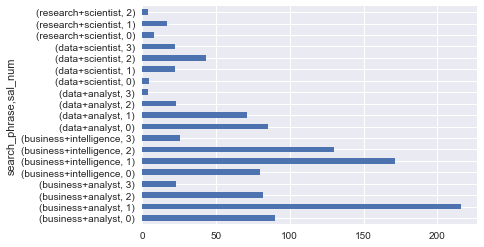

In [1371]:
df.groupby(['search_phrase','sal_num']).size().plot.barh()

---
### Use regex to find key phrases:
By investigating I found pretty common phrases:
    - 'Required education:' in 54% of all listings
    - 'Required experience:' in 65% of all listings
Find 'high value' phrases:
    - 'PhD' and various spellings
    - I would have liked to include a list of skills based on price bracket here but didn't have time
        - Valuable: 'Hadoop','Spark','AWS','R','python','svm' etc.
        - Less valuable: 'excel','microsoft' etc.
I also wanted to pull the number before the word year/years for phrases like:
    - 2-4 years experience required.
    - 5+ years experience in data science prefered.

In [555]:
#education
edu = df['job_summary'].str.extract('((Required education: )\w+)',expand=False)
edu_col = edu[0].str.extract(r': (\w+)',expand=False)
edu_col.value_counts()

Bachelor     529
Master        53
Doctorate     10
High          10
Associate     10
Educación      1
Name: 0, dtype: int64

In [1123]:
#map the values according to my assumptions of each value
edu_col = edu_col.map({np.nan:10,'Educación':1,'High':1,'Associate':2,'Bachelor':20,'Master':60,'Doctorate':500})

In [1124]:
edu[0].count()/len(edu)

0.54634581105169344

In [1125]:
#experience
exp = df['job_summary'].str.extract('((Required experience: ).+)',expand=False)
exp_col = exp[0].str.extractall(r'(\d+)\syear')
exp_col = pd.to_numeric(exp_col[0])
exp_col = exp_col.groupby(level=[0]).sum()

In [1126]:
exp[0].count()/len(exp)

0.65418894830659535

In [1127]:
phd_col = df['job_summary'].str.extract('(PHD|phd|PhD|P.h.D.)',expand=False)
phd_col = phd_col.map({np.nan:0,'PhD':5})

In [1128]:
#best so far for numerics before year
#job_df = df['job_summary'].str.extract('([\d\S+-A-Z]+[\W\D]+(years|year))',expand=False)
#job_df.to_csv('years.csv',index=False)

In [1129]:
job_col.head()

,,0,1,2
,match,,,
0,0,2,-,4
4,0,0,-,1
6,0,2,+,NaN
7,0,6,NaN,NaN
8,0,2,+,NaN


In [1265]:
#pulling number before word: year|years
job = pd.read_csv('years.csv')
job_col = job['0'].str.extractall(r'(\d)(\S?)(\d*)\syear')
y_min = job_col[0]
y_ind = job_col[1]
#y_ind = y_ind.map({'-':10,'+':100})
y_max = job_col[2]
y_min = pd.to_numeric(y_min)
y_max = pd.to_numeric(y_max)
y_min = y_min.groupby(level=[0]).sum()
y_max = y_max.groupby(level=[0]).sum()
#y_max = y_max*20
y_ind = y_ind.groupby(level=[0]).unique()

In [1266]:
group = [edu_col,exp_col,phd_col,y_min,y_max]
ext_df = pd.concat(group,axis=1)

In [1267]:
ext_df = ext_df.fillna(0)

In [1268]:
X = ext_df
y = df['sal_num']
#break sal into 
y = y.map({0:0,1:0,2:1,3:1})

In [1269]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X)

In [1270]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.4)

In [1271]:
#baselines:
# .44
# .682

In [1272]:
#clf = RandomForestClassifier(n_estimators=200,random_state=42,criterion='entropy') #did very poorly on 
#clf = RandomForestClassifier(n_estimators=200,random_state=42,criterion='gini')
#clf = LogisticRegression(penalty='l1',C=10) #.454 with l1,c=10  #C=1,L1,.639
#clf = LogisticRegression() #job only, .64
#clf = MultinomialNB()
#clf = SVC(C=1,kernel='poly',degree=2) #takes waaaay too long
#clf = SVC(C=10,gamma=10,kernel='linear',random_state=42) #c=10,.646 (both job+title)
clf = KNeighborsClassifier(n_neighbors=10,metric='manhattan') #.732 with 35,manhattan, now .71
#clf = KNeighborsClassifier(n_neighbors=25)#,metric='manhattan') #.732 with 35,manhattan, now .71

In [1273]:
clf.fit(X_train,y_train)
#cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
cross_val_score(clf,X_train,y_train,cv=10).mean()

0.65817968978636232

In [1274]:
y_pred = clf.predict(X_test)

In [1275]:
clf.score(X_test,y_test)

0.71046770601336307

In [1276]:
confusion_matrix(y_pred, y_test)

array([[290, 110],
       [ 20,  29]])

---
### Bag of Words Approach

Use CountVectorizer to create bag of words for:
    - Job titles
    - Job summarys
    
Count Vectorizer:
    - min_df, max_df were very important when trimming words from the initial bag.
    - n_grams 1,3 were most indicative
    - output:
        - ~20k for job summary
        - ~227 for job title

NMF:
    - Further trim words down to a reasonable size with L1 regularization
    - Give the ability to select # of topics like 
    - Can examine the output to see which topics its creating

Multiply NMF back against Bag of Words:
    - Creates a sparse matrix with word counts weighted by their NMF score

Added the regex data from above which increased the score by ~5%

In [2684]:
X_job = df['job_summary']
X_title = df['job_title']
y_all = df['sal_num']

In [2685]:
#create bag of words for job summary
cvt_job      =  CountVectorizer(stop_words=stop,
                            strip_accents='unicode', 
                            ngram_range=(1,3),
                            max_df=.84, #was. 84
                            min_df=4, #was 4
                            tokenizer=LemmaTokenizer())
X_job_cvt    =  cvt_job.fit_transform(X_job)

In [2686]:
#create bag of words for job title
cvt_title      =  CountVectorizer(stop_words=stop,
                            strip_accents='unicode', 
                            ngram_range=(1,2),
                            max_df=.7,
                            min_df=5, #was 5
                            tokenizer=LemmaTokenizer())
X_title_cvt    =  cvt_title.fit_transform(X_title)

In [2687]:
print(X_job_cvt.shape)
print(X_title_cvt.shape)

(1122, 20886)
(1122, 171)


In [2688]:
tf_job = TfidfTransformer()
X_job = tf_job.fit_transform(X_job_cvt)

tf_title = TfidfTransformer()
X_title = tf_title.fit_transform(X_title_cvt)

In [2689]:
n_titles=5
n_jobs=4

nmf_title = NMF(n_components=n_titles, #was 8
          random_state=42, 
          alpha=.12, #was .12
          l1_ratio=.9, 
          init='nndsvd').fit(X_title)

nmf_job = NMF(n_components=n_jobs, #was 4
          random_state=42, 
          alpha=.15, #was .15
          l1_ratio=.7, 
          init='nndsvd').fit(X_job)

In [2690]:
nmf_job_df = pd.DataFrame(nmf_job.components_, columns = cvt_job.get_feature_names())
nmf_job_df = nmf_job_df.replace(0,np.nan)
nmf_job_df = nmf_job_df.dropna(how='all',axis=1)
nmf_job_df = nmf_job_df.replace(np.nan,0)

nmf_title_df = pd.DataFrame(nmf_title.components_, columns = cvt_title.get_feature_names())
nmf_title_df = nmf_title_df.replace(0,np.nan)
nmf_title_df = nmf_title_df.dropna(how='all',axis=1)
nmf_title_df = nmf_title_df.replace(np.nan,0)

In [2691]:
print(nmf_job_df.shape)
print(nmf_title_df.shape)

(4, 2037)
(5, 92)


---
### NMF keywords found for each bag of words:
Job Title:
    - data, learning, machine, machine learning, scientist
    - project, requirement, system, data, team
    - sale, customer, account, product, prospect
    - salient, n/a, government, crgt, salient crg <- In Washington DC theyre hiring like 180 data analysts at cgrt
Job Summary:
    - business analyst, business, analyst, senior business, senior
    - data analyst, data, analyst, analyst, senior data, senior
    - scientist, data scientist, data, research, research scientist <- Interesting to see it sees research scientists similar to data scientists
    - developer, senior, etl, sharepoint dev, software dev
    - manager, project, project manager, senior, business

In [2705]:
nmf_job_df.T.sort_values(3,ascending=False).head()

,0,1,2,3
salient,0.00000,0.0,0.0,0.282601
n/a,0.00000,0.0,0.0,0.181486
government,0.05827,0.0,0.0,0.114894
crgt,0.00000,0.0,0.0,0.114006
salient crgt,0.00000,0.0,0.0,0.114006


In [2793]:
nmf_title_df.T.sort_values(2,ascending=False).head()

,0,1,2,3,4
scientist,0.0,0.000000,3.500644,0.000000,0.000000
data scientist,0.0,0.000000,3.181482,0.000000,0.000000
data,0.0,4.293569,2.385226,0.059512,0.002343
research,0.0,0.043742,0.455421,0.000000,0.000000
research scientist,0.0,0.000000,0.381193,0.000000,0.000000


In [2695]:
#create a single feature set with both reduced bag of words models
X_nmf = pd.DataFrame()
#for i, j in enumerate(['gov','manu','bank','health','insurance']):
for i in range(n_jobs):
    X_nmf = pd.concat([X_nmf,pd.DataFrame(np.matmul(X_job_cvt.toarray(),nmf_job.components_[i]),columns=[i])],axis=1)
for i in range(n_titles):
    X_nmf = pd.concat([X_nmf,pd.DataFrame(np.matmul(X_title_cvt.toarray(),nmf_title.components_[i]),columns=[i])],axis=1)
X_nmf = pd.concat([X_nmf,ext_df],axis=1)

In [2696]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X_nmf)

In [2697]:
#X = df['job_summary']
#X = X_nmf
#y = df['title_num']
y = df['sal_num']
#y = df['search_phrase']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.4)

In [2698]:
clf = RandomForestClassifier(n_estimators=150,random_state=42,criterion='entropy') 
#150,entropy .57 with 3,4,.12,.15, job and title and sal info, after fixed the X_nmf thing
#150,entropy .594 with 3,9,.12,.15, job and title and sal info, after fixed the X_nmf thing
#150,entropy .572 with 5,5,.12,.15, job and title and sal info, after fixed the X_nmf thing
#150,entropy .623 with nmfs 5,5, max_df 4,5, job and title and sal info, after fixed the X_nmf thing

#clf = LogisticRegression(penalty='l2',C=10) #C=1,L1,.639 (job only)
#clf = LogisticRegression() #job only, .64
#clf = KNeighborsClassifier(n_neighbors=25)#,metric='manhattan')
#clf = SVC(C=10,gamma=10,kernel='linear',random_state=42) #c=10,.646 (both job+title)

In [2699]:
clf.fit(X_train,y_train)
#cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
cross_val_score(clf,X_train,y_train,cv=10).mean()

0.54647681325812414

In [2700]:
y_pred = clf.predict(X_test)
y_total_pred = clf.predict(X_nmf)

In [2701]:
from sklearn.metrics import confusion_matrix

In [2702]:
clf.score(X_test,y_test)

0.59242761692650336

In [2643]:
confusion_matrix(y_pred, y_test)

array([[ 60,  30,   1,   3],
       [ 53, 138,  51,  13],
       [  5,  30,  48,   9],
       [  0,   0,   2,   6]])

---
### NMF investigation to cluster industry jobs:

In [2712]:
df = pd.read_csv('industry_df.csv',encoding='latin1') #EDA different clusters of words
#df = pd.read_csv('juniorsenior_df',encoding='latin1') #94% with randomforrest nmf
#df = pd.read_csv('salary_df.csv',encoding='latin1') #15% above baseline

In [2714]:
X_job = df['job_summary']
y_all = df['search_phrase_num']

#create bag of words for job summary
cvt_job      =  CountVectorizer(stop_words=stop,
                            strip_accents='unicode', 
                            ngram_range=(1,3),
                            max_df=.86, #was. 84
                            min_df=4, #was 4
                            tokenizer=LemmaTokenizer())
X_job_cvt    =  cvt_job.fit_transform(X_job)

In [2716]:
tf_job = TfidfTransformer()
X_job = tf_job.fit_transform(X_job_cvt)

In [2717]:
n_jobs=5

nmf_job = NMF(n_components=n_jobs, #was 4
          random_state=42, 
          alpha=.15, #was .15
          l1_ratio=.7, 
          init='nndsvd').fit(X_job)

In [2718]:
nmf_job_df = pd.DataFrame(nmf_job.components_, columns = cvt_job.get_feature_names())
nmf_job_df = nmf_job_df.replace(0,np.nan)
nmf_job_df = nmf_job_df.dropna(how='all',axis=1)
nmf_job_df = nmf_job_df.replace(np.nan,0)

---
### Output is pretty close to what I'd expect:
    - 0: Insurance though low on list
    - 1: Manufacturing
    - 2: Customer Service/Business
    - 3: Healthcare
    - 4: Loans/Banking
    
Clustering shows the similarity between Healthcare dealing with insurance, and the Insurance dealing with medical things

In [2805]:
nmf_job_df.T.sort_values(4,ascending=False).head(10)

,0,1,2,3,4
loan,0.014644,0.0,0.000000,0.0,1.310840
mortgage,0.000000,0.0,0.000000,0.0,0.697917
loan officer,0.000000,0.0,0.000000,0.0,0.165804
officer,0.000000,0.0,0.000000,0.0,0.088668
borrower,0.000000,0.0,0.000000,0.0,0.067988
bank,0.075249,0.0,0.191452,0.0,0.044879
credit,0.054554,0.0,0.000000,0.0,0.044096
consumer loan,0.000000,0.0,0.000000,0.0,0.034207
client,0.349772,0.0,0.000000,0.0,0.033000
servicing,0.004197,0.0,0.000000,0.0,0.027114


---
### Discussion:
Would have liked to pull keywords for individual salary levels
    - Would be difficult to find similaritis across disciplines, so I would have had to separate each job title and then levels of salary
There is a lot of power in weak models
    - Realizing the benefit of adding the keywords on top of the NMF bag of words technique

---
## In the shape of a laptop... "Data Scientist" Job words

<img src="files/my_wordcloud_2.png" style="float: left; height: 600px">

---
### Conclusion:
Unstructured data is challenging
    - There is a ton of information hidden within it
    - It seems like the simplest technique is to manually pull 
        - keywords
        - key indicators
        - however this isn't scalable
    - It is very cool to see NMF custer relevant words - though using it to classify wasn't a good use case

In [ ]:
sal_df = pd.read_csv('salary_df.csv',encoding='latin1')

In [2764]:
sal_df['search_phrase'].unique()

array(['business+intelligence', 'business+analyst', 'research+scientist',
       'data+analyst', 'data+scientist'], dtype=object)

In [2765]:
ds_df = sal_df[sal_df['search_phrase'] == 'data+scientist']
bi_df = sal_df[sal_df['search_phrase'] == 'business+intelligence']
da_df = sal_df[sal_df['search_phrase'] == 'data+analyst']
ba_df = sal_df[sal_df['search_phrase'] == 'business+analyst']

In [2785]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# join tweets to a single string
#words = ' '.join(ds_df['job_summary'])
#words = ' '.join(bi_df['job_summary'])
#words = ' '.join(ba_df['job_summary'])
words = ' '.join(da_df['job_summary'])

wordcloud = WordCloud(
                      font_path='/Users/xbno/Library/Fonts/Wolf Sans SC Regular.ttf',
                      stopwords=STOPWORDS,
                      background_color='white',
                      width=3000,
                      height=2000
                     ).generate(words)

# plt.imshow(wordcloud)
# plt.axis('off')
# plt.savefig('./my_twitter_wordcloud_1.png', dpi=300)
# plt.show()

/Users/xbno/anaconda3/lib/python3.6/site-packages/wordcloud/wordcloud.py:372: UserWarning: mask image should be unsigned byte between 0 and 255. Got a float array
  warnings.warn("mask image should be unsigned byte between 0"


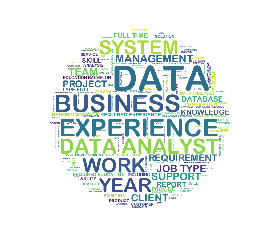

In [2786]:
from scipy.misc import imread

twitter_mask = imread('./circle3.png', flatten=True)


wordcloud = WordCloud(
                      font_path='/Users/xbno/Library/Fonts/Wolf Sans SC Regular.ttf',
                      stopwords=STOPWORDS,
                      background_color='white',
                      width=3000,
                      height=1000,
                      mask=twitter_mask
            ).generate(words)

plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('circle_wordcloud_da.png', dpi=600)
plt.show()

<img src="files/my_wordcloud_2.png" style="float: left; height: 600px">